## GDP Predcition  
#### In this notebook, I try to predict the impact of weather(heat) on economy(GDP). I use the Autoregressive Distributed Lag model(ARDL) to fit the data then use Lasso regularization to select the variables and predict the GDP at last.

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [139]:
## German gdp data process

df_gdp = pd.read_csv('gdp_de.csv')
df_gdp

,DATE,GDP
0,1970-01-01,40.260630
1,1970-04-01,41.861319
2,1970-07-01,42.643220
3,1970-10-01,43.004666
4,1971-01-01,42.178503
...,...,...
209,2022-04-01,107.909998
210,2022-07-01,108.300000
211,2022-10-01,107.860007
212,2023-01-01,107.759997


In [140]:
df_gdp.rename({'DATE':'date', 'GDP':'gdp'}, axis=1, inplace=True)
df_gdp['date'] = pd.to_datetime(df_gdp['date'])
df_gdp['year'] = df_gdp['date'].dt.year
df_gdp['month'] = df_gdp['date'].dt.month
df_gdp

,date,gdp,year,month
0,1970-01-01,40.260630,1970,1
1,1970-04-01,41.861319,1970,4
2,1970-07-01,42.643220,1970,7
3,1970-10-01,43.004666,1970,10
4,1971-01-01,42.178503,1971,1
...,...,...,...,...
209,2022-04-01,107.909998,2022,4
210,2022-07-01,108.300000,2022,7
211,2022-10-01,107.860007,2022,10
212,2023-01-01,107.759997,2023,1


In [141]:
df_gdp['quarter'] = df_gdp['month'].apply(lambda x: 'Quarter 3' if x==10 else 'Quarter 2' if x==7 else 'Quarter 1' if x==4 else 'Quarter 4')
df_gdp['year'] = df_gdp.apply(lambda x: x.year-1 if x.month==1 else x.year, axis=1)
df_gdp = df_gdp.loc[(df_gdp['year']>=1979) & (df_gdp['year']<=2019)]

df_gdp.head()

,date,gdp,year,month,quarter
37,1979-04-01,55.354685,1979,4,Quarter 1
38,1979-07-01,55.354689,1979,7,Quarter 2
39,1979-10-01,55.694010,1979,10,Quarter 3
40,1980-01-01,56.140250,1979,1,Quarter 4
41,1980-04-01,55.778818,1980,4,Quarter 1


In [143]:
## German weather process

weather_de = pd.read_csv('weather_german79_19.csv')
weather_de.head()

,nation,date,tmax,tmin,precip,month,day,year
0,Germany,1979-01-01,-7.511339,-18.412576,2.408118,1,1,1979
1,Germany,1980-01-01,0.847475,-1.895729,2.819960,1,1,1980
2,Germany,1981-01-01,4.238102,0.252797,7.562355,1,1,1981
3,Germany,1982-01-01,4.052508,2.543797,2.259762,1,1,1982
4,Germany,1983-01-01,1.599186,-2.069932,0.470876,1,1,1983


In [144]:
weather_de['quarter'] = weather_de['month'].apply(lambda x: 'Quarter 3' if x in [7, 8, 9] else 'Quarter 2' if x in [4, 5, 6] else 'Quarter 1' if x in [1, 2, 3] else 'Quarter 4')

In [145]:
weather_de.head()

,nation,date,tmax,tmin,precip,month,day,year,quarter
0,Germany,1979-01-01,-7.511339,-18.412576,2.408118,1,1,1979,Quarter 1
1,Germany,1980-01-01,0.847475,-1.895729,2.819960,1,1,1980,Quarter 1
2,Germany,1981-01-01,4.238102,0.252797,7.562355,1,1,1981,Quarter 1
3,Germany,1982-01-01,4.052508,2.543797,2.259762,1,1,1982,Quarter 1
4,Germany,1983-01-01,1.599186,-2.069932,0.470876,1,1,1983,Quarter 1


In [146]:
weather_de['high_t'] = weather_de['tmax'].apply(lambda x: 1 if x>=28 else 0)

In [147]:
de_weather = weather_de.groupby(['year', 'quarter']).agg({'tmax':'max', 'high_t':'sum', 'precip':'sum'}).reset_index()
de_weather

,year,quarter,tmax,high_t,precip
0,1979,Quarter 1,12.147407,0,264.122372
1,1979,Quarter 2,28.522254,2,324.173155
2,1979,Quarter 3,26.798305,0,263.476395
3,1979,Quarter 4,21.500797,0,254.524366
4,1980,Quarter 1,13.765576,0,207.959260
...,...,...,...,...,...
159,2018,Quarter 4,24.478378,0,203.436821
160,2019,Quarter 1,17.764865,0,251.780889
161,2019,Quarter 2,34.478919,9,180.114897
162,2019,Quarter 3,35.227027,10,208.561441


In [148]:
df_merged = pd.merge(df_gdp[['year', 'quarter', 'gdp']], de_weather[['year', 'quarter', 'tmax', 'high_t', 'precip']], on=['year', 'quarter'])
df_merged

,year,quarter,gdp,tmax,high_t,precip
0,1979,Quarter 1,55.354685,12.147407,0,264.122372
1,1979,Quarter 2,55.354689,28.522254,2,324.173155
2,1979,Quarter 3,55.694010,26.798305,0,263.476395
3,1979,Quarter 4,56.140250,21.500797,0,254.524366
4,1980,Quarter 1,55.778818,13.765576,0,207.959260
...,...,...,...,...,...,...
159,2018,Quarter 4,107.287501,24.478378,0,203.436821
160,2019,Quarter 1,107.247502,17.764865,0,251.780889
161,2019,Quarter 2,107.227498,34.478919,9,180.114897
162,2019,Quarter 3,107.547498,35.227027,10,208.561441


In [151]:
dummy = pd.get_dummies(df_merged['quarter'], drop_first=True)
df_merged = pd.concat([df_merged, dummy], axis=1)
df_merged

,year,quarter,gdp,tmax,high_t,precip,Quarter 2,Quarter 3,Quarter 4
0,1979,Quarter 1,55.354685,12.147407,0,264.122372,False,False,False
1,1979,Quarter 2,55.354689,28.522254,2,324.173155,True,False,False
2,1979,Quarter 3,55.694010,26.798305,0,263.476395,False,True,False
3,1979,Quarter 4,56.140250,21.500797,0,254.524366,False,False,True
4,1980,Quarter 1,55.778818,13.765576,0,207.959260,False,False,False
...,...,...,...,...,...,...,...,...,...
159,2018,Quarter 4,107.287501,24.478378,0,203.436821,False,False,True
160,2019,Quarter 1,107.247502,17.764865,0,251.780889,False,False,False
161,2019,Quarter 2,107.227498,34.478919,9,180.114897,True,False,False
162,2019,Quarter 3,107.547498,35.227027,10,208.561441,False,True,False


In [153]:
from copy import deepcopy as dc

def shift_lag_data(df, n_lags):
    df = dc(df)
    df.set_index('year', inplace=True)
    
    for i in range(1, n_lags+1):
        df[f'gdp(t-{i})'] = df['gdp'].shift(i)
        df[f'tmax(t-{i})'] = df['tmax'].shift(i)
        df[f'high_t(t-{i})'] = df['high_t'].shift(i)
        df[f'precip(t-{i})'] = df['precip'].shift(i)
    df.dropna(inplace=True)
    
    return df

shifted_df_4 = shift_lag_data(df_merged, 4)
shifted_df_4

,quarter,gdp,tmax,high_t,precip,Quarter 2,Quarter 3,Quarter 4,gdp(t-1),tmax(t-1),...,high_t(t-2),precip(t-2),gdp(t-3),tmax(t-3),high_t(t-3),precip(t-3),gdp(t-4),tmax(t-4),high_t(t-4),precip(t-4)
year,,,,,,,,,,,,,,,,,,,,,
1980,Quarter 1,55.778818,13.765576,0,207.959260,False,False,False,56.140250,21.500797,...,0.0,263.476395,55.354689,28.522254,2.0,324.173155,55.354685,12.147407,0.0,264.122372
1980,Quarter 2,55.557531,28.859898,1,311.493559,True,False,False,55.778818,13.765576,...,0.0,254.524366,55.694010,26.798305,0.0,263.476395,55.354689,28.522254,2.0,324.173155
1980,Quarter 3,55.483772,28.615475,1,343.525905,False,True,False,55.557531,28.859898,...,0.0,207.959260,56.140250,21.500797,0.0,254.524366,55.694010,26.798305,0.0,263.476395
1980,Quarter 4,56.143955,16.827441,0,238.518137,False,False,True,55.483772,28.615475,...,1.0,311.493559,55.778818,13.765576,0.0,207.959260,56.140250,21.500797,0.0,254.524366
1981,Quarter 1,56.003802,15.180000,0,296.072548,False,False,False,56.143955,16.827441,...,1.0,343.525905,55.557531,28.859898,1.0,311.493559,55.778818,13.765576,0.0,207.959260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,Quarter 4,107.287501,24.478378,0,203.436821,False,False,True,106.557489,33.746486,...,3.0,152.944001,106.637488,14.632973,0.0,233.939036,105.777511,21.914054,0.0,301.849390
2019,Quarter 1,107.247502,17.764865,0,251.780889,False,False,False,107.287501,24.478378,...,22.0,144.186857,105.647510,28.659459,3.0,152.944001,106.637488,14.632973,0.0,233.939036
2019,Quarter 2,107.227498,34.478919,9,180.114897,True,False,False,107.247502,17.764865,...,0.0,203.436821,106.557489,33.746486,22.0,144.186857,105.647510,28.659459,3.0,152.944001


In [154]:
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model as lm
import scipy as sp

In [170]:
X = sm.add_constant(shifted_df_4.iloc[:, 2:])
y = shifted_df_4['gdp']
model = sm.OLS(y, X.astype(float)).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gdp   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3004.
Date:                Sat, 02 Sep 2023   Prob (F-statistic):          1.74e-172
Time:                        16:15:11   Log-Likelihood:                -169.40
No. Observations:                 160   AIC:                             384.8
Df Residuals:                     137   BIC:                             455.5
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.3290      1.575      0.844      0.400      -1.786       4.444
tmax           -0.0417      0.030     -1.378      0.171      -0.102       0.018
high_t          0.0244      0.020      1.222      0.224      -0.015       0.064
precip          0.0004      0.001      0.342      0.733      -0.002       0.003
Quarter 2       0.3364      0.767      0.439      0.662      -1.180       1.853
Quarter 3       0.8143      0.960      0.848      0.398      -1.085       2.713
Quarter 4       0.6270      0.641      0.978      0.330      -0.641       1.895
gdp(t-1)        1.1342      0.089     12.769      0.000       0.959       1.310
tmax(t-1)      -0.0106      0.030     -0.351      0.726      -0.070       0.049
high_t(t-1)    -0.0031      0.020     -0.156      0.877      -0.043       0.037
precip(t-1)    -0.0009      0.001     -0.751      0.454      -0.003       0.002
gdp(t-2)        0.0072      0.134      0.054      0.957      -0.258       0.273
tmax(t-2)      -0.0172      0.031     -0.562      0.575      -0.078       0.043
high_t(t-2)    -0.0116      0.020     -0.591      0.555      -0.050       0.027
precip(t-2)    -0.0009      0.001     -0.703      0.483      -0.003       0.002
gdp(t-3)       -0.0740      0.134     -0.553      0.581      -0.339       0.191
tmax(t-3)       0.0359      0.030      1.189      0.236      -0.024       0.096
high_t(t-3)    -0.0016      0.019     -0.084      0.933      -0.040       0.037
precip(t-3)    -0.0012      0.001     -0.954      0.342      -0.004       0.001
gdp(t-4)       -0.0673      0.089     -0.759      0.449      -0.242       0.108
tmax(t-4)      -0.0230      0.030     -0.759      0.449      -0.083       0.037
high_t(t-4)  4.928e-05      0.019      0.003      0.998      -0.038       0.038
precip(t-4)     0.0015      0.001      1.228      0.222      -0.001       0.004
==============================================================================
Omnibus:                       63.919   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.204
Skew:                          -1.363   Prob(JB):                     1.46e-71
Kurtosis:                       9.442   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [172]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

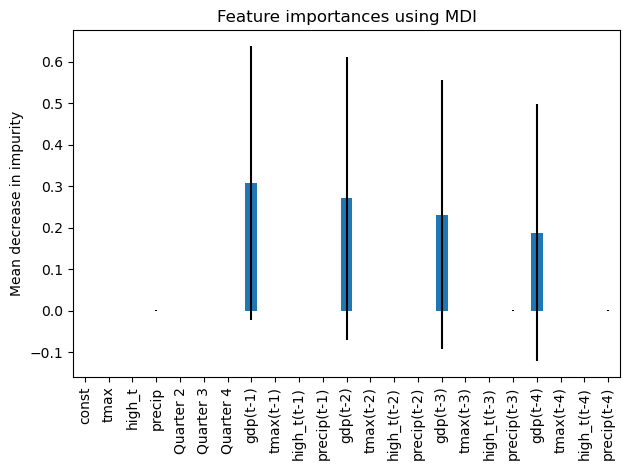

In [229]:
## Random Forest variable selection by feature importance

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
feature_names = X.columns.to_list()
forest = RandomForestRegressor(random_state=100)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(forest.feature_importances_, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig('RFR.png')

In [196]:
## Variable Selection by Lasso regression

from sklearn.model_selection import cross_validate
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.01)
model.fit(X_train, y_train)

print(f"model score on training data: {model.score(X_train, y_train)}")
print(f"model score on test data: {model.score(X_test, y_test)}")

model score on training data: 0.9977339310183173
model score on test data: 0.9984656945386241


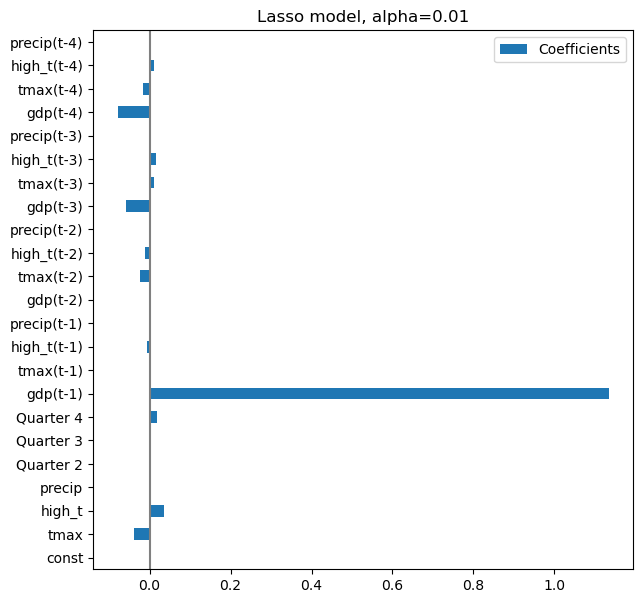

In [230]:
coefs = pd.DataFrame(
    model.coef_, columns=["Coefficients"], index=X_train.columns
)

coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Lasso model, alpha=0.01")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)
plt.savefig('lasso.png')

In [200]:
from sklearn.metrics import mean_squared_error as mse
y_pred = model.predict(X_test)
mse(y_pred, y_test)

0.32633835198632866

In [221]:
test_pred = pd.concat([y_test.to_frame().reset_index(), pd.DataFrame(y_pred, columns=['gdp_predicted'])], axis=1)

In [226]:
test_pred.sort_index(inplace=True)

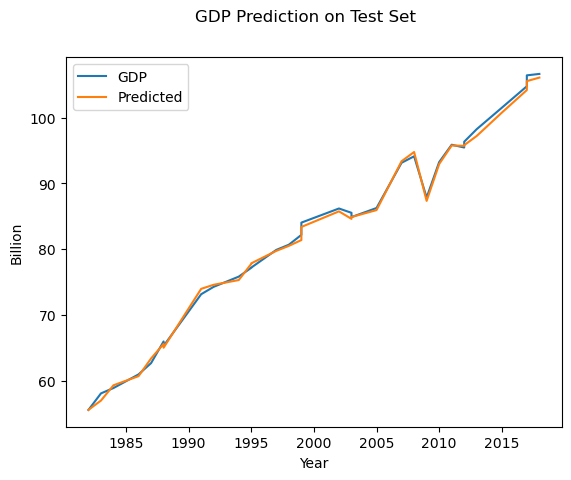

In [231]:
plt.plot(test_pred['gdp'], label='GDP')
plt.plot(test_pred['gdp_predicted'], label='Predicted')
plt.xlabel('Year')
plt.ylabel('Billion')
plt.suptitle('GDP Prediction on Test Set')
plt.legend()
plt.savefig('lasso_prediction.png')